---
title: Backscattering Coefficients
jupyter:
  kernelspec:
    name: "microwave-remote-sensing"
    language: "python"
    display_name: "microwave-remote-sensing"
---


In this notebook, we will introduce some of the steps involved in the processing of Sentinel-1 Level1 Ground Range Detected (`GRD`) data to $\sigma^0$ (`sig0`) and $\gamma^0$ (`gmr`). Moreover, the notebook illustrates the importance and impact of geometric and radiometric terrain correction. As the processing of SAR data is a very time and hardware-intense task, we won't perform the actual processing in this notebook. Instead, data at different processing steps is illustrated to highlight the impact of the processing steps.


In [15]:
import hvplot.xarray  # noqa: F401
import intake
import matplotlib.pyplot as plt  # noqa: F401
import numpy as np
import rioxarray  # noqa: F401
import xarray as xr

## Loading Backscatter Data

We first load our data from the following [intake](https://intake.readthedocs.io/en/latest/) catalog. Intake is somewhat similar to STAC in that it makes it easy to discover and load data. More importantly, this package allows us to hide some of the complexities involved with getting the data in the right format, which are not of concern in this notebook.


In [16]:
uri = "https://git.geo.tuwien.ac.at/public_projects/microwave-remote-sensing/-/raw/main/microwave-remote-sensing.yml"
cat = intake.open_catalog(uri)
gtc_dc = cat["gtc"].read().compute()
gtc_dc

<xarray.Dataset> Size: 116MB
Dimensions:      (band: 2, y: 3800, x: 3801)
Coordinates:
  * band         (band) <U8 64B 'grd' 'sig0_gtc'
    spatial_ref  int64 8B 0
  * x            (x) float64 30kB 9.5 9.5 9.5 9.5 9.501 ... 10.0 10.0 10.0 10.0
  * y            (y) float64 30kB 47.5 47.5 47.5 47.5 ... 47.0 47.0 47.0 47.0
Data variables:
    band_data    (band, y, x) float32 116MB 151.0 119.0 119.0 ... nan nan nan

In [17]:
gtc_dc.hvplot.image(
    x="x",
    y="y",
    robust=True,
    data_aspect=1,
    cmap="Greys_r",
    groupby="band",
    rasterize=True,
).opts(frame_height=600, framewise=False, aspect="equal")

/home/mschobbe/Documents/notebooks/eo-datascience/.conda_envs/microwave-remote-sensing/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


BokehModel(combine_events=True, render_bundle={'docs_json': {'410d0add-0dd5-45ce-80ca-9cc0f35c60ac': {'version…

*Figure 2: The ground range detected values and geometrically terrain corrected values can be selected on the right-hand side of the graphic.*

The geometrically terrain corrected values from the `gtc_dc` object (Figure 1) can be approximated to a certain extent, as we have sufficiently detailed information of topography in this area. This corrects for at least one typically occurring distortion in mountainous regions: "foreshortening".

![](../../images/side_looking_image_distortions.png)

*Figure 3: Side Looking radar distortions (script Chapter 4).*

Foreshortening can be spotted by eye, as it often has a radiometric consequence, where unusually bright areas fringe mountain ridges; a phenomenon called "highlighting". This geometric artifact occurs due to the compression of the distance in the image of slopes facing the radar system and the consequentially higher density of scatterers per unit length. Now let's zoom in on an example from the same datacube and display the original and corrected values side-by-side.


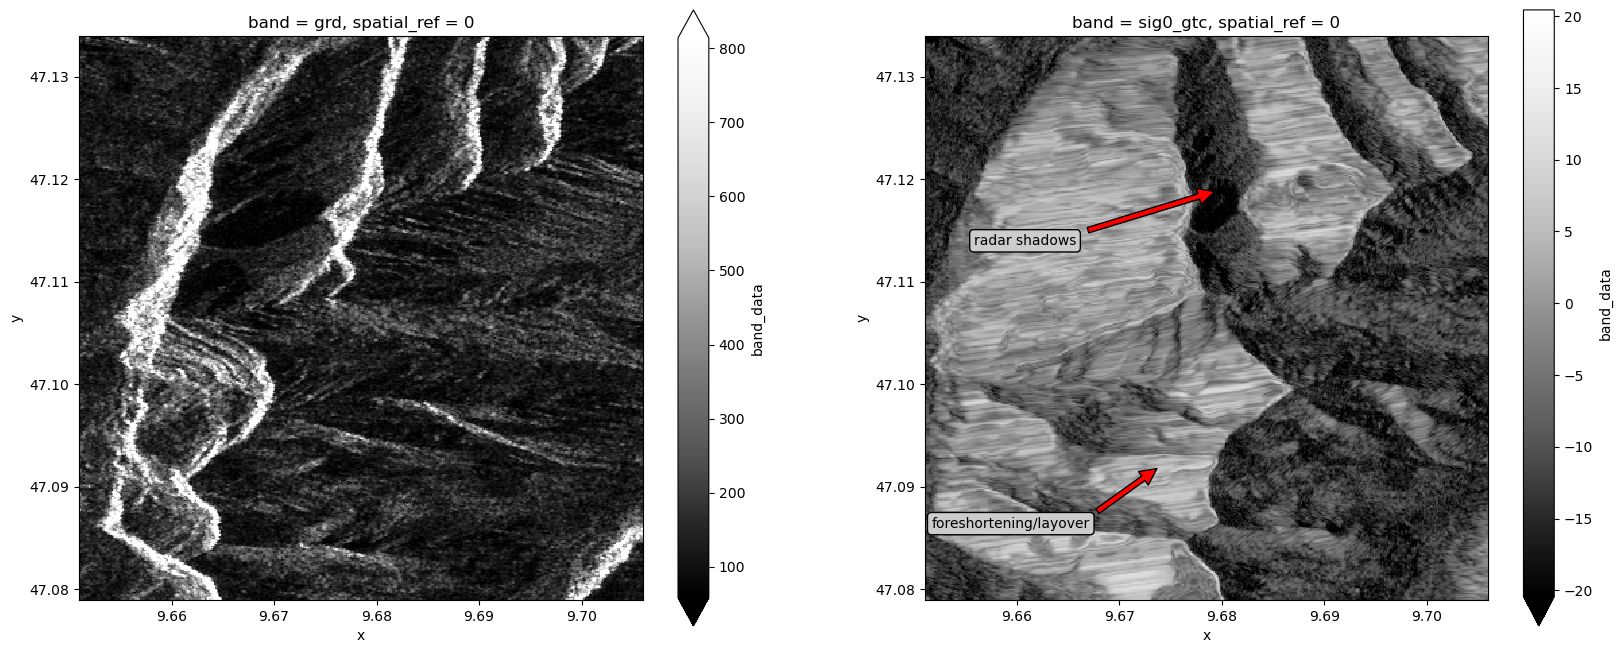

In [18]:
for_dc = gtc_dc.sel(x=slice(9.651, 9.706), y=slice(47.134, 47.079)).band_data

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

bbox = dict(boxstyle="round", fc="0.8")


ax[1].annotate(
    "foreshortening/layover",
    xy=(9.674, 47.092),
    xytext=(0.574, 0.192),
    textcoords="subfigure fraction",
    bbox=bbox,
    arrowprops=dict(facecolor="red", shrink=0.05),
)
ax[1].annotate(
    "radar shadows",
    xy=(9.68, 47.119),
    xytext=(0.6, 0.625),
    textcoords="subfigure fraction",
    bbox=bbox,
    arrowprops=dict(facecolor="red", shrink=0.05),
)

ax[0].axes.set_aspect("equal")
ax[1].axes.set_aspect("equal")

for_dc.sel(band="grd").plot(ax=ax[0], robust=True, cmap="Greys_r")
for_dc.sel(band="sig0_gtc").plot(ax=ax[1], robust=True, cmap="Greys_r")

*Figure 4: Close-up inspection of geometric distortions in side-looking radar*

As we can see, not all the geometric distortions can be corrected by the algorithm. Some of the pixels at the mountain ranges appear stretched, as in these areas not enough valid measurements are available. Moreover, we can see dark areas which are indicating radar shadows. These are image areas that could not be captured by the radar sensor and have values close to the noise floor of the Sensor (minimum detectable signal strength) ~ -28dB. It is important to note, that radar shadows are not the same for every image, as they depend on the acquisition geometry, in particular, the incidence angle and the flight direction of the satellite.

## Backscattering Coefficients

In this chapter, we will look at some of the different backscatter coefficients in more detail ($\sigma^0_E$ or $\gamma^0_E$), where both coefficients are geometrically terrain corrected. The difference is the plane of the reference area, which is the ground area as a tangent on an ellipsoidal Earth model for $\sigma^0_E$ and perpendicular to the line of sight for $\gamma^0_E$ (Figure 5). For this, we load a new datacube which includes $\sigma^0_E$ and the Incidence Angle for each pixel. We visualize the cube with the same method as before.


In [19]:
coef_dc = cat.coef.read().compute()
coef_dc.hvplot.image(
    x="x",
    y="y",
    robust=True,
    data_aspect=1,
    cmap="Greys_r",
    groupby="band",
    rasterize=True,
).opts(frame_height=600, framewise=False, aspect="equal")

BokehModel(combine_events=True, render_bundle={'docs_json': {'aba3f577-36ea-4bdc-ba58-62e973a67d83': {'version…

*Figure 5: The $\sigma^0_E$ and the incidence angle can be selected on the right-hand side of the graphic.*

In Figure 5 we can see the incidence angle image of our scene. We can see, that it depicts the differences between near to far range, but not the actual terrain as it refers to the ellipsoid. The slight patterns of the terrain that are visible are originating from the geometric terrain correction. We will use this information now to convert our ($\sigma^0_E$ to $\gamma^0_E$) with the following equation (equation 6.20 in the script):

$$ \gamma^0_E = \sigma^0_E / \cos(\theta_i) $$

We can perform this transformation with basic `numpy` operations on the `xarray` datacube.


In [20]:
# linear scale
sig0_db = coef_dc.sel(band="sig0_gtc") / 10
sig0_lin = 10 ** (coef_dc.sel(band="sig0_gtc") / 10)
# conversion to gamma
gam0_lin = sig0_lin / np.cos(np.radians(coef_dc.sel(band="incidence_angle")))
# dB scale
gam0_db = 10 * np.log(gam0_lin)
# add to existing cube
coef_dc = xr.concat(
    [coef_dc.sel(band="sig0_gtc"), gam0_db.expand_dims(band=["gam0_gtc"])], dim="band"
)

coef_dc.hvplot.image(
    x="x",
    y="y",
    robust=False,
    data_aspect=1,
    cmap="Greys_r",
    groupby="band",
    rasterize=True,
).opts(frame_height=600, framewise=False, aspect="equal")

BokehModel(combine_events=True, render_bundle={'docs_json': {'4051c255-f562-44bf-9c4a-a7b0dbda03c0': {'version…

*Figure 6: $\sigma^0_E$, and $\gamma^0_E$ can be selected on the right-hand side of the graphic.*

Comparing $\sigma^0_E$ and $\gamma^0_E$ in the figure, we can see that both look identical except for the range. This is because the only difference between $\sigma^0_E$ and $\gamma^0_E$ is the change of the reference area. While $\sigma^0_E$ is defined to be ground range, $\gamma^0_E$ is defined to be in the plane perpendicular to the line of sight from the sensor. This way, $\gamma^0_E$ mitigates the impact of the incidence angle. However, $\gamma^0_E$ is still based on the ellipsoid and does not account for the impact of the terrain on the radiometry.

# Radiometric Terrain Correction

So far, we corrected geometric distortions and compared the impact of the choice of the reference area. However, we still haven't corrected the backscatter intensity of pixels which are distorted by the terrain. In this last step, we will show that we can also correct radiometric artifacts to a certain degree. For this, we will load radiometrically terrain corrected (`rtc`) $\gamma^0_T$ and plot it along the other coefficients.


In [21]:
rtc_dc = cat.rtc.read().compute()

# add to existing cube
rtc_dc = xr.concat([coef_dc, rtc_dc], dim="band")

rtc_dc.hvplot.image(
    x="x",
    y="y",
    robust=True,
    data_aspect=1,
    cmap="Greys_r",
    groupby="band",
    rasterize=True,
).opts(frame_height=600, framewise=False, aspect="equal")

BokehModel(combine_events=True, render_bundle={'docs_json': {'30f195a1-2b1e-4cd1-a840-b44d71568a2e': {'version…

*Figure 7: $\sigma^0_E$, $\gamma^0_E$, and $\gamma^0_T$ can be selected on the right-hand side of the graphic.*

When comparing $\gamma^0_E$ and $\gamma^0_T$ in the plot we can clearly see the impact of the radiometric correction in the mountainous areas. This correction is necessary, because for slopes facing towards the sensor, a larger ground area contributes to the backscatter value of a slant range resolution cell, than for slopes lying in the opposite direction. This results in significant brightness changes, where foreshortening areas appear brighter and lengthening areas darker. $\gamma^0_T$ adjusts the backscatter to represent what it would be if the terrain was flat, thus reducing these effects. This significantly reduces the impact of the terrain on the backscatter values, allowing for more accurate comparisons across different terrain types and locations. The correction is done by using a DEM to determine the local illuminated area at each radar position. The above illustrated approach is also referred to as terrain flattening because in the resulting image, mountains appear flat. As $\gamma^0_T$ is corrected for geometric and radiometric distortions, it is also referred to as Normalized Radar Backscatter (NRB) and is the current standard for Analysis-Ready-Backscatter (ARD).